In [1]:
import skimage.transform
import numpy as np
from matplotlib import pyplot as plt
plt.set_cmap('terrain');

In [2]:
class terrain(object):
    def __init__(self,seed=42):
        '''self.img is the main terrain'''
        self.img = np.zeros((2,3),dtype=np.float)
        self.rand = np.random.RandomState(seed=seed)
        
    def genV1(self,imax=15,smallness=0.75,scale=1.5,maxsize=10**7):
        '''generates map that with large features first then smaller features
        This is done by adding normal noise and enlarging the array'''
        
        outsize = self.img.shape[0]*self.img.shape[1]*scale**(2*(imax-1))
        assert maxsize>outsize, 'Potential Memory error: Size = 6*scale**(2*(imax-1)) = {} is above maxsize = {}'.format(outsize,maxsize)
        
        J = smallness
        for i in range(imax):
            self.img += self.rand.normal(scale=J**i,size=self.img.shape) #add noise with amplitude J**i (J<1 thus smaller for large i)
            if i==imax-1:
                break
            self.img = skimage.transform.rescale(self.img,scale,anti_aliasing=False,mode='reflect',multichannel=False)
    
    def addseasnow(self,img,seafrac=0.5,snowfrac=0.05):
        '''adds snow and sea by clipping the self.img terrain array
        This work because the color map terrain: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
        has blue at the lowest value and white at the highest value'''
        pmin = np.percentile(img,seafrac*100)
        pmax = np.percentile(img,(1-snowfrac)*100)
        img = np.clip(img,pmin,pmax) #make snow and sea
        return img
    
    def addbeach(self,img,vmin=0.15,vmax=0.25):
        '''adds beach
        This work because the color map terrain: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
        has sand colour at the middle value'''
        Amin,Amax = np.min(img),np.max(img)
        img2 = (img-Amin)/(Amax-Amin) #rescale 0<=img2<=1
        img[(img2>vmin)*(img2<vmax)] = (Amax+Amin)/2 #set shoreline
        return img
    
    def plot(self,raw=False):
        '''simple plotter, uses terrain colour map: https://matplotlib.org/users/colormaps.html'''
        img = np.copy(self.img)
        if not raw:
            img = self.addseasnow(img)
            img = self.addbeach(img)
        plt.figure(figsize=(15,12))
        plt.imshow(img,cmap='terrain')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def erosion(self,nparticles,maxdeathfrac=0.5,nitts=100,f=0.5,f2=None):
        '''erosion inspired by: https://www.youtube.com/watch?v=eaXk97ujbPQ
        This is a homebrew version of that, 
        
        This takes a large number (nparticles) of and at each loop (uses a lot of array broadcasting to make it fast)
          1. Calculate next position as the lowest position around the particle (posnew)
          2. Calculate difference in height between those two point (DC)
          3. Change height of old position and new position (only uses difference between the heights for stability)
          4. set current position equal to next position'''
        posy = np.random.randint(0,self.img.shape[0],size=(nparticles,))
        posx = np.random.randint(0,self.img.shape[1],size=(nparticles,))
        pos = np.array([posy,posx]).T
        dirs = np.array([[0,0],[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1],[-1,0],[-1,1]]) #(y,x)
        if f2 is None:
            f2 = f
        for i in range(nitts):
            posnewpos = (dirs[:,np.newaxis,:]+pos)
            Xnew,Ynew = posnewpos[...,1],posnewpos[...,0]
            Xnew = np.clip(Xnew,0,self.img.shape[1]-1) #edge bounce
            Ynew = np.clip(Ynew,0,self.img.shape[0]-1)
            newid = np.argmin(self.img[Ynew,Xnew],axis=0)
            posnew = np.array([Ynew[newid,np.arange(Ynew.shape[1])],Xnew[newid,np.arange(Xnew.shape[1])]]).T
            
            Yo,Xo = pos.T
            Yn,Xn = posnew.T
            deathfrac = np.mean((Yo==Yn)*(Xo==Xn)) #fraction of particles that do not move
            Cold = self.img[Yo,Xo]
            Cnew = self.img[Yn,Xn]
            DC = Cold-Cnew
            self.img[Yo,Xo] -= DC/2*f #if f = 1 than Cnew = Cold
            self.img[Yn,Xn] += DC/2*f2
            
            pos = posnew 
            if maxdeathfrac<deathfrac: #reset particles if the fraction still particles is above the trashold
                posy = np.random.randint(0,self.img.shape[0],size=(nparticles,))
                posx = np.random.randint(0,self.img.shape[1],size=(nparticles,))
                pos = np.array([posy,posx]).T
        self.pos = pos #fun for showcasing particles

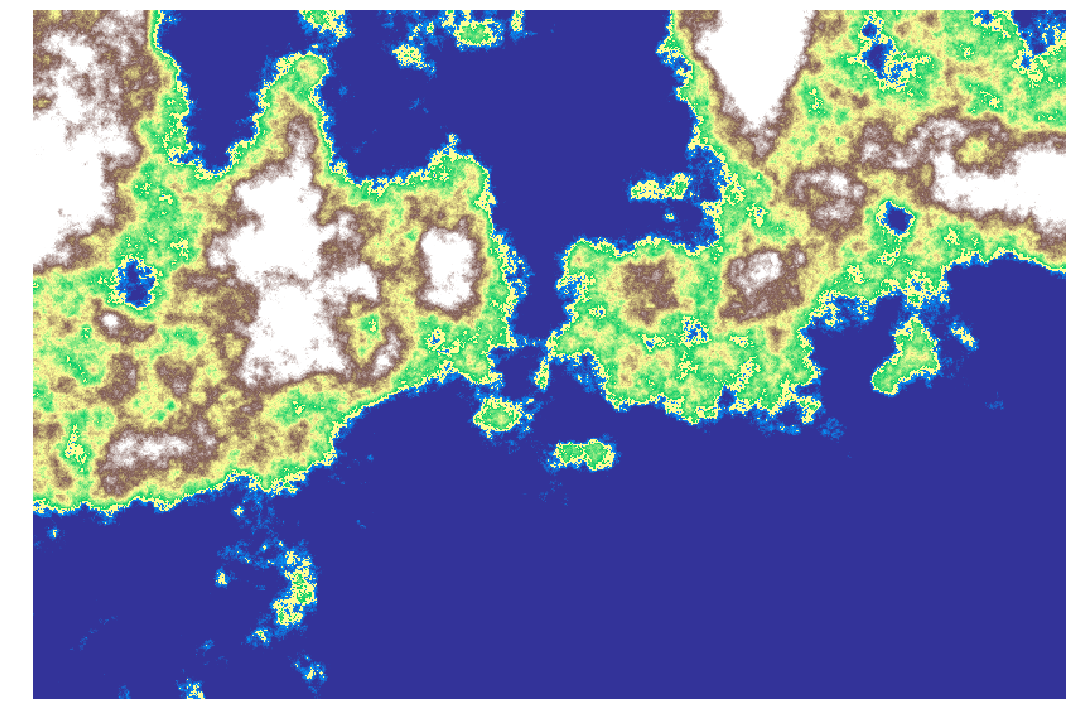

In [6]:
ter = terrain(seed=45)
ter.genV1(imax=15)
ter.plot(raw=False)

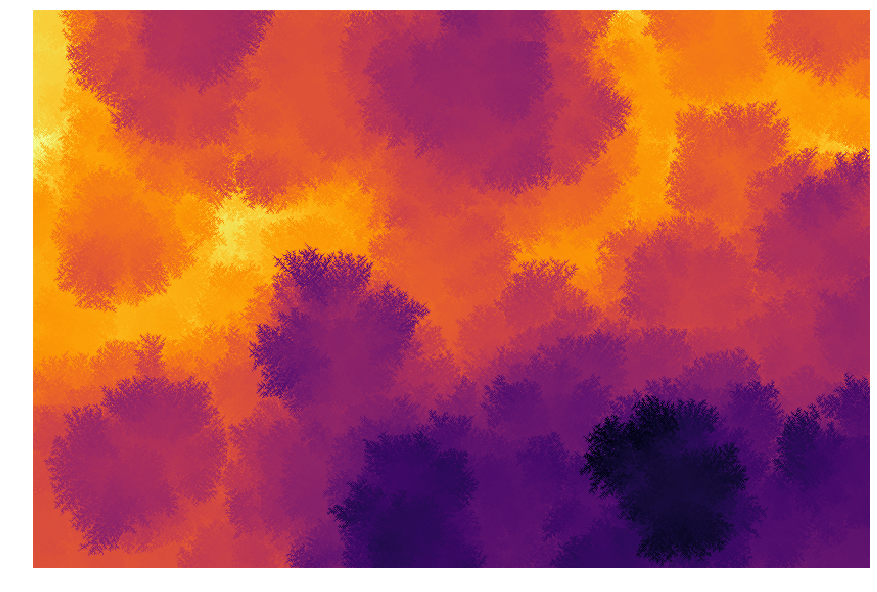

In [13]:
ter = terrain(seed=45)
ter.genV1(imax=15)
ter.erosion(80000,nitts=1000,f=0.5,f2=-0.02,maxdeathfrac=0.9)
plt.figure(figsize=(15,12))
plt.imshow(ter.img,cmap='inferno')
plt.axis('off')
plt.show()

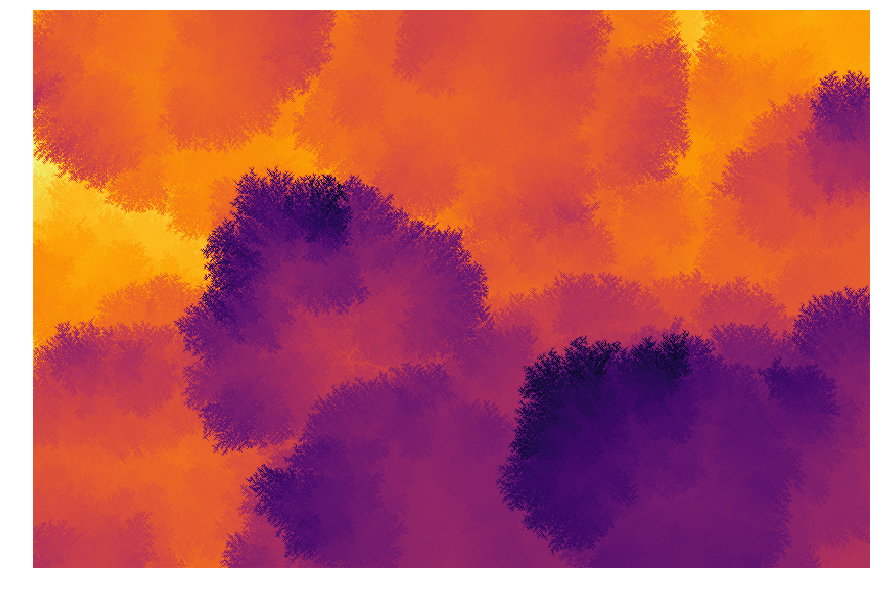

In [14]:
ter.erosion(80000,nitts=1000,f=0.5,f2=-0.02,maxdeathfrac=0.9)
plt.figure(figsize=(15,12))
plt.imshow(ter.img,cmap='inferno')
plt.axis('off')
plt.show()

In [28]:
fig = plt.figure(figsize=(15,12))
ims = []
nframes = 0
from tqdm import tqdm_notebook as tqdm
ter = terrain(seed=45)
ter.genV1(imax=15)
for i in tqdm(range(50)):
    ter.erosion(80000//50,nitts=1000,f=0.5,f2=-0.02,maxdeathfrac=0.9)
    plt.set_cmap('inferno')
    im = plt.imshow(ter.img, animated=True)
    if nframes==0: plt.axis('off')
    ims.append([im])
    nframes+=1
import matplotlib.animation as animation
from IPython.display import HTML
ani = animation.ArtistAnimation(fig, ims, interval=40, blit=True,
                        repeat_delay=1000)
vid = HTML(ani.to_html5_video())
plt.close()
vid